# How-to Guide: Creating Nested Workflows in CWL

This guide explains how to build and use nested workflows in CWL by leveraging the `SubworkflowFeatureRequirement`. 

The focus is on the workflow composition and the integration of subworkflows to create reusable components.

## Objective

* Main Workflow: Accepts inputs and calls a subworkflow (`rgb-composite`) as a single step.
* Subworkflow (`rgb-composite`): Performs a series of steps to process data and produce the desired output.

## Key Blocks

1. `SubworkflowFeatureRequirement`

* The `SubworkflowFeatureRequirement` allows workflows to include other workflows as steps.


In [1]:
cwl_file="../cwl/06-nested-workflows/nested-workflow.cwl"

cat $cwl_file | yq e .'$graph[0]' | yq '.. | select(has("SubworkflowFeatureRequirement")) | {"requirements": {"SubworkflowFeatureRequirement": .SubworkflowFeatureRequirement}}' 

requirements:
  SubworkflowFeatureRequirement: {}


2. Subworkflow Step Definition

The main workflow calls the `subworkflow` using:


In [2]:
cat $cwl_file | yq e .'$graph[0].steps' 

step_rgb_composite:
  in:
    stac-item: stac-item
    bands: bands
  out:
    - rgb-tif
  run: "#rgb-composite"




* `run: "#rgb-composite"`: Links to the `rgb-composite` subworkflow.

* Inputs and Outputs: The subworkflow accepts inputs (`stac-item`, `bands`) and produces an output (`rgb-tif`).

## Steps

1. Define the Subworkflow

The `rgb-composite` subworkflow performs the following:

* Fetch band-specific asset URLs using the `stac` tool.
* Stack the asset TIFFs into a single file using the `rio_stack` tool.
* Apply color correction to generate the RGB composite using the `rio_color` tool.



Subworkflow Definition (`rgb-composite`)

In [3]:
cat $cwl_file | yq e .'$graph[1]'  -

class: Workflow
id: rgb-composite
requirements:
  InlineJavascriptRequirement: {}
  NetworkAccess:
    networkAccess: true
  ScatterFeatureRequirement: {}
inputs:
  stac-item:
    type: string
  bands:
    type: string[]
outputs:
  rgb-tif:
    outputSource: step_color/rgb
    type: File
steps:
  step_curl:
    in:
      stac_item: stac-item
      common_band_name: bands
    out:
      - hrefs
    run: "#stac"
    scatter: common_band_name
    scatterMethod: dotproduct
  step_stack:
    in:
      tiffs:
        source: step_curl/hrefs
    out:
      - stacked
    run: "#rio_stack"
  step_color:
    in:
      stacked:
        source: step_stack/stacked
    out:
      - rgb
    run: "#rio_color"


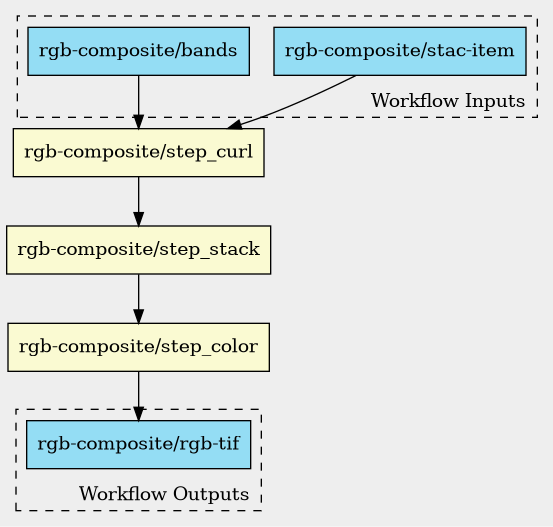

In [4]:
cwltool --print-dot $cwl_file#rgb-composite 2> /dev/null | dot -Tpng | display

2. Define the Main Workflow

The main workflow invokes the rgb-composite subworkflow:

In [5]:
cat $cwl_file | yq e .'$graph[0]'  -

class: Workflow
id: main
requirements:
  SubworkflowFeatureRequirement: {}
  InlineJavascriptRequirement: {}
  NetworkAccess:
    networkAccess: true
  ScatterFeatureRequirement: {}
inputs:
  stac-item:
    type: string
  bands:
    type: string[]
    default: ["red", "green", "blue"]
outputs:
  rgb-tif:
    outputSource: step_rgb_composite/rgb-tif
    type: File
steps:
  step_rgb_composite:
    in:
      stac-item: stac-item
      bands: bands
    out:
      - rgb-tif
    run: "#rgb-composite"


* Requirements:
  * `SubworkflowFeatureRequirement`: Enables the use of nested workflows.
  * `ScatterFeatureRequirement`: Allows processing multiple bands simultaneously.

* Inputs:
  * `stac-item`: URL to a STAC item.
  * `bands`: Array of band names (`default: ["red", "green", "blue"]`).

* Outputs:
  * `rgb-tif`: The RGB composite file produced by the subworkflow.


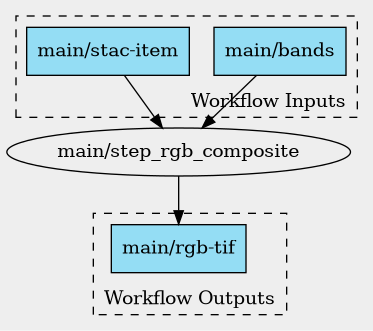

In [6]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

3. Run the Workflow

To execute the main workflow, use the following command:

```bash
cwltool nested-workflow.cwl \
  --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A 
```

In [7]:
cwltool $cwl_file --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A  > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/06-nested-workflows/nested-workflow.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/06-nested-workflows/nested-workflow.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_rgb_composite
INFO [step step_rgb_composite] start
INFO [workflow step_rgb_composite] start
INFO [workflow step_rgb_composite] starting step step_curl
INFO [step step_curl] start
INFO [job step_curl] /tmp/cg6rp0cd$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/cg6rp0cd,target=/tNqLcQ \
    --mount=type=bind,source=/tmp/f2oo3olf,target=/tmp \
    --workdir=/tNqLcQ \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/a0iy1rxo/20241229181520-593123.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/tNqLcQ \
    docker.io/curlimages/curl:latest \
    curl \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A

4. Expected Output

Intermediate Outputs:
* URLs of band-specific TIFFs (hrefs).
* Stacked TIFF file (stacked.tif).

Final Output:

* RGB composite TIFF file (rgb-tif).

In [8]:
cat output.json | yq e . -o=json -

{
  "rgb-tif": {
    "location": "file:///data/work/github/eoepca-plus/how-to/docs/rgb.tif",
    "basename": "rgb.tif",
    "class": "File",
    "checksum": "sha1$aa07cc49d63d7694625ae16cac521b279ba88c79",
    "size": 361747464,
    "path": "/data/work/github/eoepca-plus/how-to/docs/rgb.tif"
  }
}


## Key Takeaways

Modularity with Subworkflows:

* Use `SubworkflowFeatureRequirement` to encapsulate reusable workflows.
* Subworkflows simplify complex workflows by isolating specific logic.

Integration of Subworkflows:

* Define subworkflow steps in the main workflow.
* Use run to link the subworkflow.

Reusability:

* Subworkflows can be reused in multiple workflows, promoting modularity and efficiency.

This approach makes it easy to manage and scale CWL workflows by leveraging nested subworkflows.